# Colorectal histology - Final Project
Author: Gabriel TRUONG

## Exploratory Data Analysis

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Sequential
from tensorflow_datasets.image_classification import colorectal_histology
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from utils import plot_accuracy_loss


import datetime
SEED = 42

### Data Collection

In [3]:
(train_ds,train_label),(val_ds, val_label)= tfds.as_numpy(tfds.load(
    'colorectal_histology',
    split=["train[:80%]", "train[80%:]"],
    batch_size=-1,
    as_supervised=True,
))

print(type(train_ds), train_ds.shape)

2022-12-16 10:50:34.589271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-16 10:50:34.589554: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-16 10:50:34.589589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lapbeer): /proc/driver/nvidia/version does not exist
2022-12-16 10:50:34.591390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'numpy.ndarray'> (4000, 150, 150, 3)


### Visualisation of images

In [3]:
class_names = colorectal_histology._CLASS_NAMES
class_names

('tumor',
 'stroma',
 'complex',
 'lympho',
 'debris',
 'mucosa',
 'adipose',
 'empty')

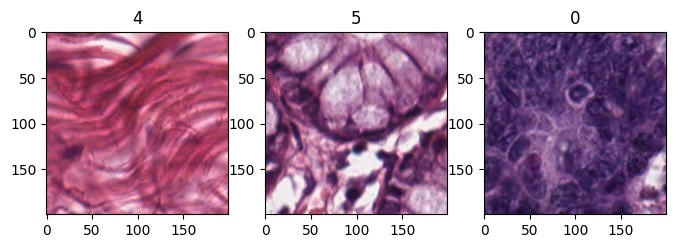

In [4]:
fig, ax = plt.subplots(1,3,figsize=(8,8))
size=(200,200)

img = [Image.fromarray(train_ds[i], 'RGB').resize(size) for i in range(4)]

ax[0].imshow(img[0],cmap = 'gray')
ax[0].set_title(train_label[0])
ax[1].imshow(img[1],cmap = 'gray')
ax[1].set_title(train_label[1])
ax[2].imshow(img[3],cmap = 'gray')
ax[2].set_title(train_label[3])
plt.show()

Text(0.5, 1.0, 'Number of occurences of a val label')

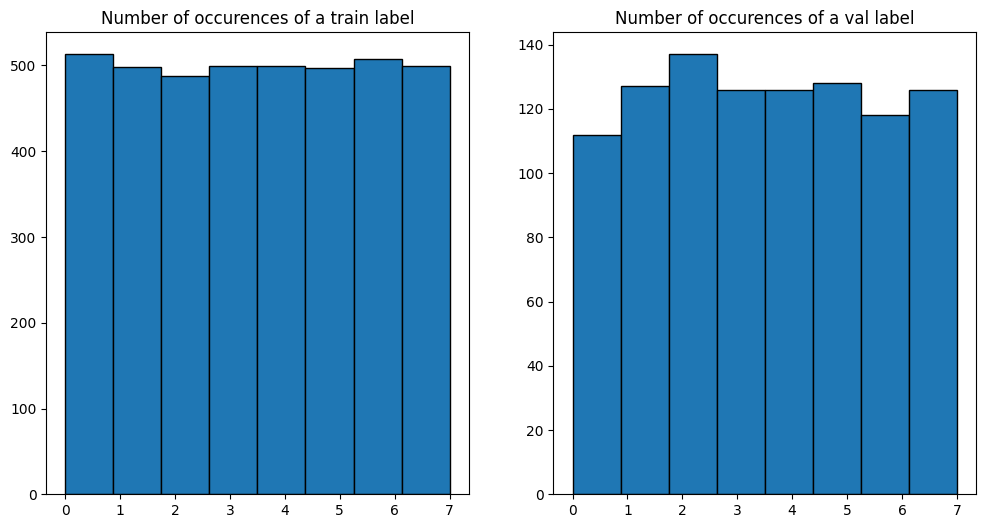

In [5]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(train_label, bins=len(np.unique(train_label)), edgecolor="black")
ax1.set_title("Number of occurences of a train label")

ax2.hist(val_label, bins=len(np.unique(val_label)), edgecolor="black")
ax2.set_title("Number of occurences of a val label")

We can see that the training set is quite balanced. The validation set is not as balanced but it enables to see how the model perform on a slightly different distribution.

In [6]:
tf.keras.utils.set_random_seed(SEED)

In [7]:
def plot_monitoring(history):
    fig,ax = plt.subplots(1,2,figsize=(10,8))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title("model accuracy")
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'test'], loc='upper left')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend(['train', 'test'], loc='upper left')
    
    fig.show()

In [8]:
%tensorboard --logdir logs/fit


UsageError: Line magic function `%tensorboard` not found.


### Baseline model

This model is simple Artificial Neural Network. The architecture comes from a lab on the fashion MNIST dataset. Since we are dealing with images, we add a flatten layer to suit the architecture. Without this preprocessing layer, not all the layers will be fully connected to the input.

In [9]:
logs = {}

baseline_model = Sequential([
    layers.Flatten(input_shape=[150, 150,3]),
    layers.Dense(300,activation="relu"),
    layers.Dense(100,activation="relu"),
    layers.Dense(8,activation="softmax")
])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 300)               20250300  
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
Total params: 20,281,208
Trainable params: 20,281,208
Non-trainable params: 0
_________________________________________________________________


In [10]:
baseline_model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")

For this baseline model, we only add a tensorboard callback to monitor the training.

In [11]:
log_dir = "logs/colorectal_project_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
baseline_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [12]:
logs["Baseline"] = baseline_model.fit(train_ds,train_label,
                            epochs=10,callbacks=baseline_cb,
                            validation_data=(val_ds,val_label))

Epoch 1/10
125/125 [==============================] - 10s 76ms/step - loss: 3682.9690 - accuracy: 0.2280 - val_loss: 1375.5201 - val_accuracy: 0.2790
Epoch 2/10
125/125 [==============================] - 8s 68ms/step - loss: 814.0372 - accuracy: 0.3573 - val_loss: 788.7551 - val_accuracy: 0.3400
Epoch 3/10
125/125 [==============================] - 11s 90ms/step - loss: 515.1431 - accuracy: 0.3810 - val_loss: 195.0034 - val_accuracy: 0.4090
Epoch 4/10
125/125 [==============================] - 13s 103ms/step - loss: 496.1483 - accuracy: 0.3817 - val_loss: 326.1843 - val_accuracy: 0.3790
Epoch 5/10
125/125 [==============================] - 10s 80ms/step - loss: 205.4439 - accuracy: 0.4543 - val_loss: 184.9726 - val_accuracy: 0.2930
Epoch 6/10
125/125 [==============================] - 9s 71ms/step - loss: 233.8676 - accuracy: 0.4142 - val_loss: 343.8136 - val_accuracy: 0.3420
Epoch 7/10
125/125 [==============================] - 9s 71ms/step - loss: 140.8293 - accuracy: 0.4545 - val_lo

In [13]:
print(baseline_model.evaluate(val_ds,val_label))
baseline_predictions=baseline_model.predict(val_ds)

32/32 [==============================] - 1s 21ms/step - loss: 89.4960 - accuracy: 0.2470
[89.49595642089844, 0.24699999392032623]
32/32 [==============================] - 1s 17ms/step


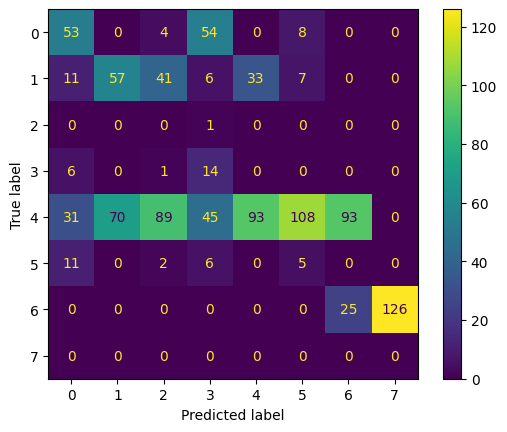

In [14]:
baseline_cm=confusion_matrix(np.argmax(baseline_predictions,axis=1),val_label)
ConfusionMatrixDisplay(baseline_cm).plot()

/tmp/ipykernel_25831/609281059.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


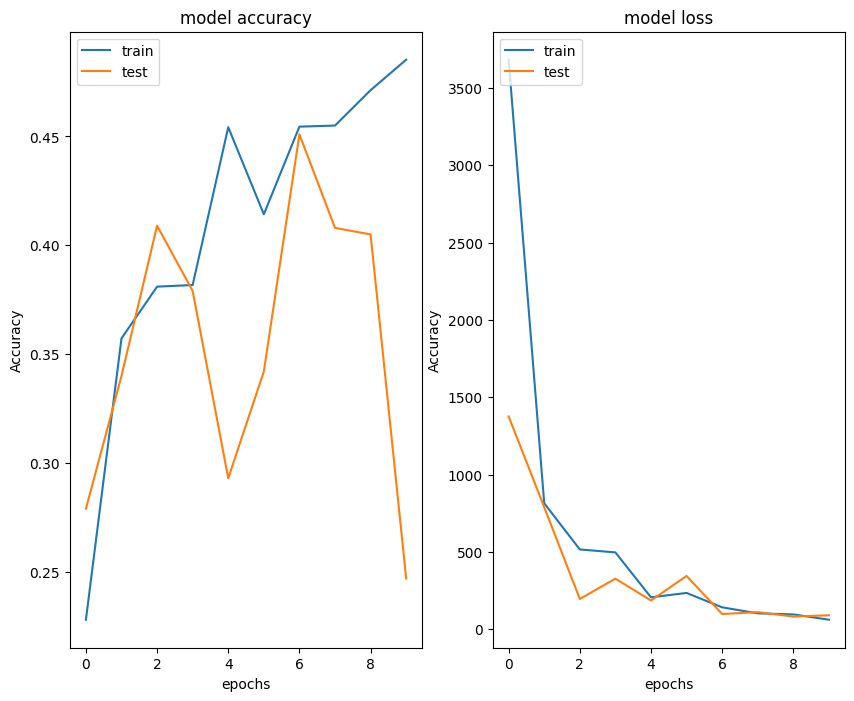

In [15]:
plot_monitoring(logs['Baseline'])

For our baseline model, we get a low accuracy on both the training and the validation set. 
Also we can see with the confusion matrix that the model only predict on few labels. We need to add complexity so that the model also predicts on the other labels.

### Convolutional Neural Network

With this model, we want to add complexity by adding more suitable layers such as Convolution2D and MaxPool2D. This model 

In [14]:
basic_cnn = Sequential([
            layers.Convolution2D(32, (3 ,3), activation='relu',input_shape=(150,150,3)),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(20, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(12, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(8, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(activation='relu', units=128),
            layers.Dense(activation='softmax', units=8),
])
basic_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 20)        5780      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 12)        2172      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 12)      

In [15]:
log_dir = "logs/colorectal_project_CNN" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
basic_CNN_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [16]:
basic_cnn.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
history_cnn=basic_cnn.fit(train_ds,train_label,
                            epochs=30,
                            validation_data=(val_ds,val_label),callbacks=basic_CNN_cb)

Epoch 1/30
125/125 [==============================] - 14s 109ms/step - loss: 2.0524 - accuracy: 0.3880 - val_loss: 0.9951 - val_accuracy: 0.6100
Epoch 2/30
125/125 [==============================] - 15s 118ms/step - loss: 1.0217 - accuracy: 0.5825 - val_loss: 0.9011 - val_accuracy: 0.6170
Epoch 3/30
125/125 [==============================] - 18s 141ms/step - loss: 0.8758 - accuracy: 0.6605 - val_loss: 0.9153 - val_accuracy: 0.6020
Epoch 4/30
125/125 [==============================] - 16s 127ms/step - loss: 0.7972 - accuracy: 0.6952 - val_loss: 0.8267 - val_accuracy: 0.6530
Epoch 5/30
125/125 [==============================] - 13s 108ms/step - loss: 0.7499 - accuracy: 0.7120 - val_loss: 0.7749 - val_accuracy: 0.6750
Epoch 6/30
125/125 [==============================] - 13s 105ms/step - loss: 0.6603 - accuracy: 0.7473 - val_loss: 0.7510 - val_accuracy: 0.7070
Epoch 7/30
125/125 [==============================] - 13s 104ms/step - loss: 0.6391 - accuracy: 0.7523 - val_loss: 0.7943 - val_ac

/home/lapbeer/Documents/epf/5A/pred_modeling/final_project/colorectal_project/utils.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


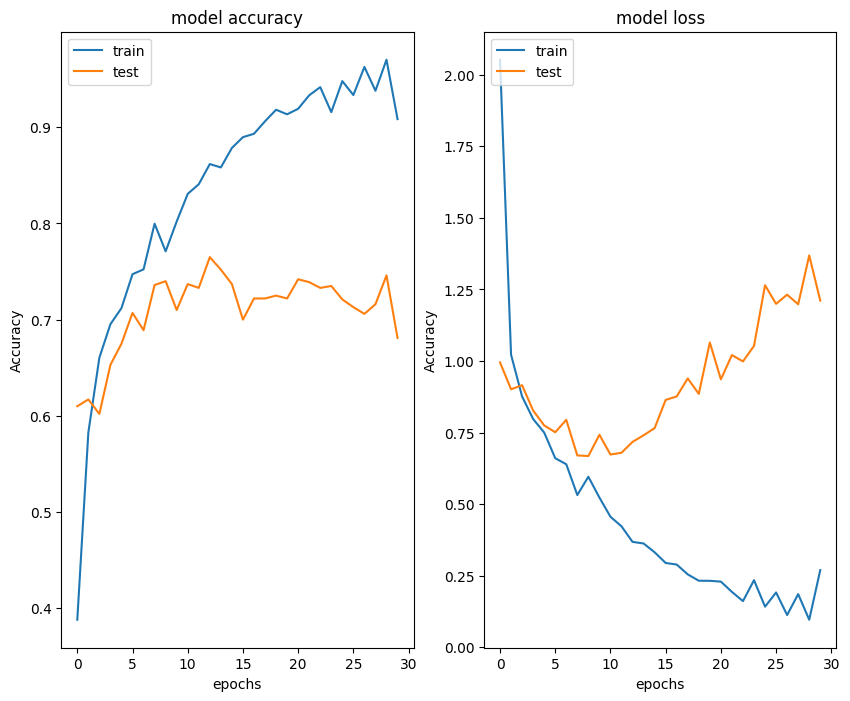

In [17]:
plot_accuracy_loss(history_cnn)

In [18]:
cnn_prediction=basic_cnn.predict(val_ds)

32/32 [==============================] - 1s 43ms/step


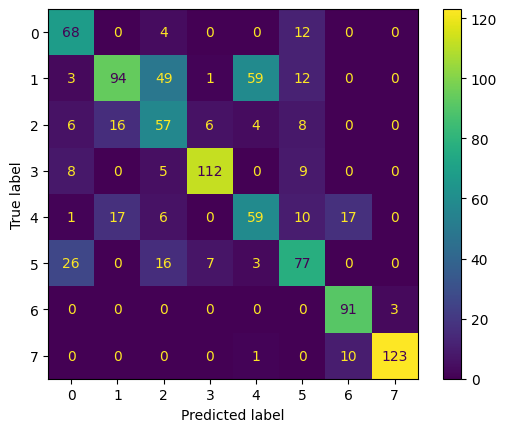

In [19]:
moredepth_cm=confusion_matrix(np.argmax(cnn_prediction,axis=1),val_label)
ConfusionMatrixDisplay(moredepth_cm).plot()

From the plots, we can clearly see that the model performs very well on the training set but not on the validation set. We reached a good generalization and now to improve the performance on the validation set we need to reduce the overfitting.

### Reduce overfitting

#### Dropout

In [30]:
drop_cnn = Sequential([
            layers.Convolution2D(64, (3 ,3), activation='relu',input_shape=(150,150,3)),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(20, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.Convolution2D(12, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(8, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(activation='relu', units=128),
            layers.Dense(activation='softmax', units=8),
])
drop_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 20)        11540     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 36, 36, 20)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 20)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 34, 34, 12)       

In [31]:
log_dir = "logs/colorectal_project_CNN" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
drop_CNN_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [32]:
drop_cnn.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
history_drop=drop_cnn.fit(train_ds,train_label,
                            epochs=30,
                            validation_data=(val_ds,val_label),callbacks=drop_CNN_cb)

Epoch 1/30
125/125 [==============================] - 30s 237ms/step - loss: 3.0453 - accuracy: 0.2973 - val_loss: 1.3213 - val_accuracy: 0.3880
Epoch 2/30
125/125 [==============================] - 29s 236ms/step - loss: 1.1241 - accuracy: 0.4930 - val_loss: 1.1353 - val_accuracy: 0.5280
Epoch 3/30
125/125 [==============================] - 31s 246ms/step - loss: 0.9807 - accuracy: 0.5785 - val_loss: 0.9104 - val_accuracy: 0.6180
Epoch 4/30
125/125 [==============================] - 30s 243ms/step - loss: 0.9965 - accuracy: 0.6075 - val_loss: 0.8924 - val_accuracy: 0.6310
Epoch 5/30
125/125 [==============================] - 29s 236ms/step - loss: 0.7739 - accuracy: 0.6985 - val_loss: 0.7559 - val_accuracy: 0.6990
Epoch 6/30
125/125 [==============================] - 29s 232ms/step - loss: 0.7660 - accuracy: 0.7057 - val_loss: 0.7414 - val_accuracy: 0.7110
Epoch 7/30
125/125 [==============================] - 31s 249ms/step - loss: 0.6336 - accuracy: 0.7623 - val_loss: 0.6748 - val_ac

#### Data Augmentation

In [ ]:
augmented_cnn = Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.2),
            layers.Convolution2D(64, (3 ,3), activation='relu',input_shape=(150,150,3)),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(20, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(12, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(8, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(activation='relu', units=128),
            layers.Dense(activation='softmax', units=8),
])
augmented_cnn.summary()

In [ ]:
log_dir = "logs/colorectal_project_CNN" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
augmented_CNN_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
augmented_cnn.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
history_augmented=augmented_cnn.fit(train_ds,train_label,
                            epochs=30,
                            validation_data=(val_ds,val_label),callbacks=augmented_CNN_cb)

Epoch 1/30
125/125 [==============================] - 30s 237ms/step - loss: 3.0453 - accuracy: 0.2973 - val_loss: 1.3213 - val_accuracy: 0.3880
Epoch 2/30
125/125 [==============================] - 29s 236ms/step - loss: 1.1241 - accuracy: 0.4930 - val_loss: 1.1353 - val_accuracy: 0.5280
Epoch 3/30
125/125 [==============================] - 31s 246ms/step - loss: 0.9807 - accuracy: 0.5785 - val_loss: 0.9104 - val_accuracy: 0.6180
Epoch 4/30
125/125 [==============================] - 30s 243ms/step - loss: 0.9965 - accuracy: 0.6075 - val_loss: 0.8924 - val_accuracy: 0.6310
Epoch 5/30
125/125 [==============================] - 29s 236ms/step - loss: 0.7739 - accuracy: 0.6985 - val_loss: 0.7559 - val_accuracy: 0.6990
Epoch 6/30
125/125 [==============================] - 29s 232ms/step - loss: 0.7660 - accuracy: 0.7057 - val_loss: 0.7414 - val_accuracy: 0.7110
Epoch 7/30
125/125 [==============================] - 31s 249ms/step - loss: 0.6336 - accuracy: 0.7623 - val_loss: 0.6748 - val_ac

### Archive

more_depth_model = Sequential([
    layers.Flatten(input_shape=[150, 150,3]),
    layers.Dense(300,activation="relu"),
    layers.Dense(100,activation="relu"),
    layers.Dense(32,activation="relu"),
    layers.Dense(8,activation="softmax")
])
more_depth_model.summary()
more_depth_model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
For this baseline model, we only add a tensorboard callback to monitor the training.
log_dir = "logs/colorectal_project_depth_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
more_depth_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

logs["more_depth"] = more_depth_model.fit(train_ds,train_label,
                            epochs=10,callbacks=more_depth_cb,
                            validation_data=(val_ds,val_label),batch_size=16)
plot_monitoring(logs['more_depth'])
print(more_depth_model.evaluate(val_ds,val_label))
more_depth_predictions=more_depth_model.predict(val_ds)
moredepth_cm=confusion_matrix(np.argmax(more_depth_predictions,axis=1),val_label)
ConfusionMatrixDisplay(moredepth_cm).plot()